# Get features from a pre-trained BERT Transformer model
The model card can be found here: https://huggingface.co/dkleczek/bert-base-polish-cased-v1

In [1]:
import torch
import numpy as np
import tqdm

## Load the model

In [2]:
from transformers import BertModel, BertTokenizer

model_name = "dkleczek/bert-base-polish-uncased-v1"

tokenizer =  BertTokenizer.from_pretrained("dkleczek/bert-base-polish-uncased-v1")
model = BertModel.from_pretrained("dkleczek/bert-base-polish-uncased-v1")

c:\Users\sergi\anaconda3\envs\olx\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Use the uncased version
This decision is made because I needed to make a decision (hehe).
I could compare case / uncased but, for time constraints, I use the uncased version.

The main reason for going towards the uncased version is because of the reduced model size and complexity.

### Do a simple test

In [3]:
input_text = "This is not polish but still should work. right?"
inputs = tokenizer(input_text, return_tensors="pt") # "pt" means returning the pytorch tensor

### Compute the embeddings

In [4]:
with torch.no_grad(): # we don't need gradient for this
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
# embeddings is a tensor of shape (batch_size, sequence_length, hidden_size)
# the 'embeddings' variable not contains the embeddings for each token in the input text

In [5]:
embeddings

tensor([[[-1.0544,  0.5917,  0.8397,  ..., -0.6307,  0.2327, -0.4002],
         [-1.3133, -0.0392, -1.0398,  ..., -0.2068, -0.1923, -0.1468],
         [-0.2293,  0.9394, -0.8461,  ..., -0.6320,  1.1495, -0.7087],
         ...,
         [-1.5325,  0.3075, -0.1446,  ..., -0.1709, -0.5319,  1.0088],
         [-1.4722,  0.5275,  0.7635,  ..., -1.1831, -1.2890, -0.3788],
         [-0.1530,  0.4941, -0.3130,  ..., -0.4510, -0.1730,  0.0717]]])

### Transform to sentence embeddings
Here there are some alternatives.
The two most basic ones are getting the mean or max pooling.

Mean pooling may provide a smoother representetion and be less sensitive to outliers, but may dilute important tokens.
Max pooling may highlight important features and focus on key tokens, but would be more sensitive to outliers.

It seems to me that mean pooling could work good for titles, and max pooling for descriptions.
But one should test both and see which gives better results.

In [6]:
def get_sentence_embeddings_from_word_embeddings(word_embeddings, method="mean"):
    if method == "mean":
        return word_embeddings.mean(dim=1)
    elif method == "max":
        return word_embeddings.max(dim=1).values # max is returning both the max values and the indices of the max values. We only want the max values
    else:
        raise ValueError(f"Method {method} not supported. Please use 'mean' or 'max'.")

In [7]:
sentence_embeddings = get_sentence_embeddings_from_word_embeddings(embeddings)
print(np.shape(sentence_embeddings.numpy()))

(1, 768)


## Import custom library for computing the embeddings
From the above code, we refactor it to a quite simple class, and import it

In [8]:
import sys, os 
sys.path.append(os.getcwd() + "/../src")

from BERT_embeddings import BERTEmbeddings

In [9]:
bert_embeddings = BERTEmbeddings()

### Load the data

In [10]:
from data_preprocessing import DataPreprocessing

dp = DataPreprocessing(df_path="../data/real_estate_ads_2022_10.csv", 
                       train_indices_path="../data/train_indices.npy", 
                       test_indices_path="../data/test_indices.npy")

dp.Y

,standard_cbrt_price_per_m
0,-1.418692
1,-0.950694
2,-1.677240
3,-0.346889
4,-0.268792
...,...
73640,-0.270301
73641,-0.517942
73642,-0.952708
73643,-0.775382


### Get maximum (tokenized) lengths for titles and description

In [11]:
max_title_length = dp.X["title"].apply(lambda x: len(x) if isinstance(x,str) else 0).max()
max_description_length = dp.X["description"].apply(lambda x: len(x) if isinstance(x,str) else 0).max()

max_title_length, max_description_length

(50, 18692)

<Axes: >

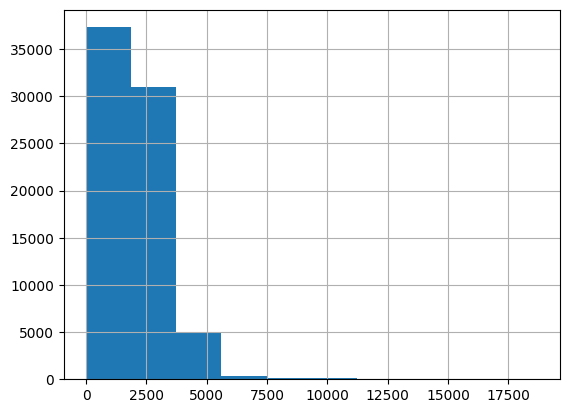

In [12]:
dp.X["description"].apply(lambda x: len(x) if isinstance(x,str) else 0).hist()

We could use some truncation (truncation=True, max_length=something) for the tokenizer, to make it more efficient
However, token length is not the same as character length.
One should repeat this process, by applying the tokenizer.

The default value is 512 tokens, which correspond to approximately 2500 characters (although one should check this for polish, for this specific tokenizer)

### Compute the embeddings for the titles

This could be made more efficient by converting titles into numpy, and batching appropiately.

For ease in the implementation, I just use the apply pandas method (the progress_apply is just to get progress)

In [13]:
"""
tqdm.tqdm.pandas()
titles = dp.X["title"].apply(lambda x: str(x))
sentence_embeddings = titles.progress_apply(lambda x: bert_embeddings.get_sentence_embeddings(x))
"""

'\ntqdm.tqdm.pandas()\ntitles = dp.X["title"].apply(lambda x: str(x))\nsentence_embeddings = titles.progress_apply(lambda x: bert_embeddings.get_sentence_embeddings(x))\n'

Too slow unfortunately... trying out some batching for pandas.
Of course, enabling GPU is better. But I don't have CUDA in this maching :()

In [17]:
titles = dp.X["title"].apply(lambda x: str(x))
titles = titles.to_list()

batch_size = 1000

sentence_embeddings = []

for i in tqdm.tqdm(range(0, len(titles), batch_size)):
    batch = titles[i:i+batch_size]
    embeddings = bert_embeddings.get_sentence_embeddings(batch)
    torch.save(embeddings, f"../data/bert_embeddings/title_embeddings_batch_size_{batch_size}_{i}.pt")

100%|██████████| 74/74 [38:52<00:00, 31.52s/it]


In [20]:
descriptions = dp.X["description"].apply(lambda x: str(x))
descriptions = descriptions.to_list()

batch_size = 200

for i in tqdm.tqdm(range(0, len(titles), batch_size)):
    batch = descriptions[i:i+batch_size]
    embeddings = bert_embeddings.get_sentence_embeddings(batch)
    torch.save(embeddings, f"../data/bert_embeddings/description_embeddings_batch_size_{batch_size}_{i}.pt")

  0%|          | 0/74 [01:12<?, ?it/s]


Still slow :( :(((  I wish I had CUDA here.

I could install some intel extensions for improved CPU performance, but most seem to be only for Linux.
Some options are quantizing the model, finding smaller models, etc